packages
==============

In [38]:
import numpy as np
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import dataset
===================

In [39]:
from tensorflow.keras.datasets import cifar10
(X_train_numpy, Y_train_numpy), (X_test_numpy, Y_test_numpy) = cifar10.load_data()

In [40]:
label = {0:"airplane", 1:"automobile", 2:"bird", 3:"cat", 4:"deer", 
         5:"dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}

show image
-------------------

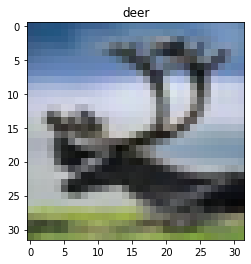

In [41]:
def show_image(i):
    plt.imshow(X_train_numpy[i])
    plt.title(f"{label.get(Y_train_numpy[i][0])}")
    plt.show()
show_image(46506)

data prepare
-------------------------
1. transfer axis from [N, x, y, in_channel] to [N, in_channel, x, y]
2. to torch

In [42]:
X_test = torch.from_numpy(np.rollaxis(X_test_numpy, 3, 1)).type(torch.FloatTensor)
X_train = torch.from_numpy(np.rollaxis(X_train_numpy, 3, 1)).type(torch.FloatTensor)
Y_train = torch.from_numpy(Y_train_numpy).type(torch.long).view(50000)
Y_test = torch.from_numpy(Y_test_numpy).type(torch.long).view(10000)

In [43]:
print(f"{Y_train.size()}, {Y_test.size()}")

torch.Size([50000]), torch.Size([10000])


In [44]:
X_test.div_(255)
X_train.div_(255)
X_train[0]

tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
         [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
         [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
         ...,
         [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
         [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
         [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],

        [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
         [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
         [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
         ...,
         [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
         [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
         [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],

        [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
         [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
         [0.0824, 0.0000, 0.0314,  ..., 0.1961, 0.1961, 0.

In [45]:
X_train.size()

torch.Size([50000, 3, 32, 32])

CNN1
============================

In [46]:
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3) # 32 * 32 -> 30 * 30 
        self.conv2 = nn.Conv2d(32, 32, 3) # 30 * 30 -> 28 * 28 -> 14 * 14
        self.conv3 = nn.Conv2d(32, 64, 3) # 14 * 14 -> 12 * 12
        self.conv4 = nn.Conv2d(64, 64, 3) # 12 * 12 -> 10 * 10 -> 5 * 5 
        self.fc1   = nn.Linear(64 * 5 * 5, 3000)
        self.fc2   = nn.Linear(3000, 1000)
        self.fc3   = nn.Linear(1000, 10)
        self.softmax = nn.Softmax(dim=1)
        self.ce = nn.CrossEntropyLoss()
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    def forward(self, x):
        x = F.relu(self.conv1(x)) # the same as (2, 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(F.relu(self.conv4(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # x = F.sigmoid(self.fc1(x))
        # x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        x = self.softmax(x)
        return x

    # x.size(0) = y.size(0)
    def loss(self, x, y):
        loss = self.ce(x, y)
        return loss

net1 = CNN1().cuda()
print(net1)

CNN1(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=3000, bias=True)
  (fc2): Linear(in_features=3000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
  (ce): CrossEntropyLoss()
)


CNN2
====================

In [22]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 5) # 32 * 32 -> 28 * 28 -> 14 * 14 
        self.conv2 = nn.Conv2d(10, 20, 5) # 14 * 14 -> 10 * 10 -> 5 * 5 
        self.fc1   = nn.Linear(20 * 5 * 5, 50)
        self.fc2   = nn.Linear(50, 10)
        self.softmax = nn.Softmax(dim=1)
        self.ce = nn.CrossEntropyLoss()
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2) # the same as (2, 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) # the same as (2, 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.softmax(x)
        return x

    # x.size(0) = y.size(0)
    def loss(self, x, y):
        loss = self.ce(x, y)
        return loss

net2 = CNN2().cuda()
print(net2)

CNN2(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
  (ce): CrossEntropyLoss()
)


Update CNN1
===================

In [32]:
from tqdm.notebook import tnrange, tqdm_notebook

In [33]:
Y_train.size()

torch.Size([50000])

in 0/0: loss is 2.302581548690796, accu is 0.101
in 100/0: loss is 2.3025474548339844, accu is 0.101
in 200/0: loss is 2.302516460418701, accu is 0.1015
in 300/0: loss is 2.3024845123291016, accu is 0.1465
in 400/0: loss is 2.3024532794952393, accu is 0.162
in 500/0: loss is 2.302419662475586, accu is 0.158
in 600/0: loss is 2.302384376525879, accu is 0.1485
in 700/0: loss is 2.3023455142974854, accu is 0.1315
in 800/0: loss is 2.3023035526275635, accu is 0.1145
in 900/0: loss is 2.3022565841674805, accu is 0.11



in 0/1: loss is 2.3022894859313965, accu is 0.1085
in 100/1: loss is 2.302189826965332, accu is 0.118
in 200/1: loss is 2.3020777702331543, accu is 0.141
in 300/1: loss is 2.3019442558288574, accu is 0.161
in 400/1: loss is 2.3017725944519043, accu is 0.1625
in 500/1: loss is 2.301530361175537, accu is 0.157
in 600/1: loss is 2.3011364936828613, accu is 0.137
in 700/1: loss is 2.3002941608428955, accu is 0.113
in 800/1: loss is 2.297126293182373, accu is 0.102
in 900/1: loss is 2.285722255706787, accu is 0.1025



in 0/2: loss is 2.254357099533081, accu is 0.2025
in 100/2: loss is 2.218569278717041, accu is 0.2275
in 200/2: loss is 2.1888556480407715, accu is 0.259
in 300/2: loss is 2.169586420059204, accu is 0.281
in 400/2: loss is 2.141341209411621, accu is 0.317
in 500/2: loss is 2.1421899795532227, accu is 0.3135
in 600/2: loss is 2.0982983112335205, accu is 0.3635
in 700/2: loss is 2.0748038291931152, accu is 0.391
in 800/2: loss is 2.07182240486145, accu is 0.3835
in 900/2: loss is 2.0383684635162354, accu is 0.4285



in 0/3: loss is 2.1589810848236084, accu is 0.293
in 100/3: loss is 2.0320088863372803, accu is 0.4365
in 200/3: loss is 2.017669439315796, accu is 0.4485
in 300/3: loss is 1.9513930082321167, accu is 0.5185
in 400/3: loss is 1.930551528930664, accu is 0.539
in 500/3: loss is 1.8522346019744873, accu is 0.6195
in 600/3: loss is 1.817355751991272, accu is 0.6515
in 700/3: loss is 1.7341806888580322, accu is 0.729
in 800/3: loss is 1.735313892364502, accu is 0.7305
in 900/3: loss is 1.6749268770217896, accu is 0.7835



in 0/4: loss is 2.112699508666992, accu is 0.3425
in 100/4: loss is 1.9260663986206055, accu is 0.541
in 200/4: loss is 1.7304874658584595, accu is 0.7325
in 300/4: loss is 1.6868224143981934, accu is 0.7725
in 400/4: loss is 1.677851915359497, accu is 0.779
in 500/4: loss is 1.6754674911499023, accu is 0.781
in 600/4: loss is 1.6735303401947021, accu is 0.7825
in 700/4: loss is 1.6713687181472778, accu is 0.7845
in 800/4: loss is 1.6697289943695068, accu is 0.786
in 900/4: loss is 1.6683193445205688, accu is 0.7875



in 0/5: loss is 2.085437297821045, accu is 0.374
in 100/5: loss is 1.8232388496398926, accu is 0.644
in 200/5: loss is 1.6920785903930664, accu is 0.769
in 300/5: loss is 1.6713573932647705, accu is 0.7855
in 400/5: loss is 1.6668701171875, accu is 0.791
in 500/5: loss is 1.6583420038223267, accu is 0.798
in 600/5: loss is 1.6546823978424072, accu is 0.8015
in 700/5: loss is 1.6522799730300903, accu is 0.804
in 800/5: loss is 1.6490931510925293, accu is 0.807
in 900/5: loss is 1.6475661993026733, accu is 0.8085



in 0/6: loss is 2.092005729675293, accu is 0.361
in 100/6: loss is 1.8884267807006836, accu is 0.5705
in 200/6: loss is 1.6809550523757935, accu is 0.776
in 300/6: loss is 1.6723549365997314, accu is 0.784
in 400/6: loss is 1.6684139966964722, accu is 0.7875
in 500/6: loss is 1.6633949279785156, accu is 0.7925
in 600/6: loss is 1.6607656478881836, accu is 0.795
in 700/6: loss is 1.6591272354125977, accu is 0.7965
in 800/6: loss is 1.6586071252822876, accu is 0.797
in 900/6: loss is 1.6566203832626343, accu is 0.799



in 0/7: loss is 2.1077868938446045, accu is 0.3475
in 100/7: loss is 1.7088500261306763, accu is 0.751
in 200/7: loss is 1.681361436843872, accu is 0.7755
in 300/7: loss is 1.6730854511260986, accu is 0.783
in 400/7: loss is 1.666968822479248, accu is 0.789
in 500/7: loss is 1.6624932289123535, accu is 0.7935
in 600/7: loss is 1.657482624053955, accu is 0.7985
in 700/7: loss is 1.654030680656433, accu is 0.802
in 800/7: loss is 1.6523936986923218, accu is 0.8035
in 900/7: loss is 1.6494598388671875, accu is 0.8065



in 0/8: loss is 2.0909671783447266, accu is 0.3595
in 100/8: loss is 1.695942997932434, accu is 0.7665
in 200/8: loss is 1.6661584377288818, accu is 0.7905
in 300/8: loss is 1.6600345373153687, accu is 0.7965
in 400/8: loss is 1.6553455591201782, accu is 0.801
in 500/8: loss is 1.6527632474899292, accu is 0.8035
in 600/8: loss is 1.6511582136154175, accu is 0.805
in 700/8: loss is 1.6497048139572144, accu is 0.8065
in 800/8: loss is 1.6491272449493408, accu is 0.807
in 900/8: loss is 1.6458061933517456, accu is 0.8105



in 0/9: loss is 2.095977306365967, accu is 0.3595
in 100/9: loss is 1.704503059387207, accu is 0.7535
in 200/9: loss is 1.667129397392273, accu is 0.791
in 300/9: loss is 1.6503840684890747, accu is 0.8065
in 400/9: loss is 1.6450954675674438, accu is 0.8115
in 500/9: loss is 1.6418778896331787, accu is 0.8145
in 600/9: loss is 1.639821171760559, accu is 0.8165
in 700/9: loss is 1.636303424835205, accu is 0.82
in 800/9: loss is 1.635201334953308, accu is 0.821
in 900/9: loss is 1.6328060626983643, accu is 0.8235



in 0/10: loss is 2.084439992904663, accu is 0.3715
in 100/10: loss is 1.6804383993148804, accu is 0.777
in 200/10: loss is 1.662172555923462, accu is 0.7945
in 300/10: loss is 1.6408863067626953, accu is 0.816
in 400/10: loss is 1.6311781406402588, accu is 0.8255
in 500/10: loss is 1.628890872001648, accu is 0.8275
in 600/10: loss is 1.626305103302002, accu is 0.83
in 700/10: loss is 1.6233699321746826, accu is 0.833
in 800/10: loss is 1.6203042268753052, accu is 0.836
in 900/10: loss is 1.6173518896102905, accu is 0.839



in 0/11: loss is 2.0750133991241455, accu is 0.38
in 100/11: loss is 1.6930559873580933, accu is 0.764
in 200/11: loss is 1.680546760559082, accu is 0.776
in 300/11: loss is 1.6757512092590332, accu is 0.7805
in 400/11: loss is 1.6720376014709473, accu is 0.784
in 500/11: loss is 1.668065071105957, accu is 0.788
in 600/11: loss is 1.6656793355941772, accu is 0.7905
in 700/11: loss is 1.6630951166152954, accu is 0.793
in 800/11: loss is 1.6602113246917725, accu is 0.796
in 900/11: loss is 1.6580207347869873, accu is 0.798



in 0/12: loss is 2.062664747238159, accu is 0.394
in 100/12: loss is 1.6968775987625122, accu is 0.7605
in 200/12: loss is 1.683025598526001, accu is 0.7735
in 300/12: loss is 1.6774064302444458, accu is 0.779
in 400/12: loss is 1.6721713542938232, accu is 0.784
in 500/12: loss is 1.6705775260925293, accu is 0.7855
in 600/12: loss is 1.6671090126037598, accu is 0.789
in 700/12: loss is 1.6655579805374146, accu is 0.7905
in 800/12: loss is 1.6640350818634033, accu is 0.792
in 900/12: loss is 1.6616204977035522, accu is 0.7945



in 0/13: loss is 2.0772781372070312, accu is 0.3725
in 100/13: loss is 1.6758909225463867, accu is 0.7815
in 200/13: loss is 1.6668075323104858, accu is 0.79
in 300/13: loss is 1.6628679037094116, accu is 0.7935
in 400/13: loss is 1.6597989797592163, accu is 0.7965
in 500/13: loss is 1.6567498445510864, accu is 0.7995
in 600/13: loss is 1.6542279720306396, accu is 0.802
in 700/13: loss is 1.6508078575134277, accu is 0.8055
in 800/13: loss is 1.6492301225662231, accu is 0.807
in 900/13: loss is 1.6467268466949463, accu is 0.8095



in 0/14: loss is 2.077587604522705, accu is 0.381
in 100/14: loss is 1.6785374879837036, accu is 0.779
in 200/14: loss is 1.6606593132019043, accu is 0.796
in 300/14: loss is 1.6553047895431519, accu is 0.801
in 400/14: loss is 1.6450450420379639, accu is 0.8115
in 500/14: loss is 1.6428102254867554, accu is 0.8135
in 600/14: loss is 1.6407972574234009, accu is 0.8155
in 700/14: loss is 1.637463092803955, accu is 0.819
in 800/14: loss is 1.6333688497543335, accu is 0.823
in 900/14: loss is 1.6317859888076782, accu is 0.8245



in 0/15: loss is 2.0702712535858154, accu is 0.3845
in 100/15: loss is 1.677455186843872, accu is 0.7795
in 200/15: loss is 1.6531891822814941, accu is 0.8035
in 300/15: loss is 1.6441643238067627, accu is 0.8125
in 400/15: loss is 1.6395787000656128, accu is 0.817
in 500/15: loss is 1.6375114917755127, accu is 0.819
in 600/15: loss is 1.63361656665802, accu is 0.823
in 700/15: loss is 1.6311582326889038, accu is 0.8255
in 800/15: loss is 1.6297045946121216, accu is 0.827
in 900/15: loss is 1.6292345523834229, accu is 0.8275



in 0/16: loss is 2.0867080688476562, accu is 0.37
in 100/16: loss is 1.6885710954666138, accu is 0.7685
in 200/16: loss is 1.680992603302002, accu is 0.7755
in 300/16: loss is 1.6784815788269043, accu is 0.7775
in 400/16: loss is 1.6710892915725708, accu is 0.785
in 500/16: loss is 1.6631330251693726, accu is 0.793
in 600/16: loss is 1.6614409685134888, accu is 0.7945
in 700/16: loss is 1.6555827856063843, accu is 0.8005
in 800/16: loss is 1.6545262336730957, accu is 0.8015
in 900/16: loss is 1.6534640789031982, accu is 0.8025



in 0/17: loss is 2.060553789138794, accu is 0.397
in 100/17: loss is 1.7087469100952148, accu is 0.7475
in 200/17: loss is 1.6930283308029175, accu is 0.763
in 300/17: loss is 1.6881613731384277, accu is 0.7675
in 400/17: loss is 1.68343186378479, accu is 0.7725
in 500/17: loss is 1.6762830018997192, accu is 0.7795
in 600/17: loss is 1.671849012374878, accu is 0.784
in 700/17: loss is 1.6688178777694702, accu is 0.787
in 800/17: loss is 1.6657615900039673, accu is 0.79
in 900/17: loss is 1.6628551483154297, accu is 0.793



in 0/18: loss is 2.0712780952453613, accu is 0.382
in 100/18: loss is 1.691664695739746, accu is 0.765
in 200/18: loss is 1.6753138303756714, accu is 0.7815
in 300/18: loss is 1.6712948083877563, accu is 0.785
in 400/18: loss is 1.6664613485336304, accu is 0.79
in 500/18: loss is 1.664689540863037, accu is 0.7915
in 600/18: loss is 1.661694049835205, accu is 0.7945
in 700/18: loss is 1.6577590703964233, accu is 0.7985
in 800/18: loss is 1.6529203653335571, accu is 0.8035
in 900/18: loss is 1.6512466669082642, accu is 0.805



in 0/19: loss is 2.0713789463043213, accu is 0.386
in 100/19: loss is 1.6647745370864868, accu is 0.7925
in 200/19: loss is 1.656191349029541, accu is 0.8005
in 300/19: loss is 1.6506062746047974, accu is 0.806
in 400/19: loss is 1.6446541547775269, accu is 0.812
in 500/19: loss is 1.6401846408843994, accu is 0.8165
in 600/19: loss is 1.6366361379623413, accu is 0.82
in 700/19: loss is 1.6355832815170288, accu is 0.821
in 800/19: loss is 1.6336439847946167, accu is 0.823
in 900/19: loss is 1.6312199831008911, accu is 0.8255



in 0/20: loss is 2.0545709133148193, accu is 0.4025
in 100/20: loss is 1.6931023597717285, accu is 0.764
in 200/20: loss is 1.673913598060608, accu is 0.783
in 300/20: loss is 1.6657326221466064, accu is 0.791
in 400/20: loss is 1.6615933179855347, accu is 0.795
in 500/20: loss is 1.6593807935714722, accu is 0.797
in 600/20: loss is 1.657260537147522, accu is 0.799
in 700/20: loss is 1.6543530225753784, accu is 0.802
in 800/20: loss is 1.6507964134216309, accu is 0.8055
in 900/20: loss is 1.6502501964569092, accu is 0.806



in 0/21: loss is 2.0712106227874756, accu is 0.382
in 100/21: loss is 1.6906616687774658, accu is 0.7655
in 200/21: loss is 1.673078179359436, accu is 0.783
in 300/21: loss is 1.6674131155014038, accu is 0.7885
in 400/21: loss is 1.6628910303115845, accu is 0.793
in 500/21: loss is 1.659827470779419, accu is 0.796
in 600/21: loss is 1.6566286087036133, accu is 0.8
in 700/21: loss is 1.6513758897781372, accu is 0.805
in 800/21: loss is 1.6460506916046143, accu is 0.8105
in 900/21: loss is 1.6425639390945435, accu is 0.814



in 0/22: loss is 2.066150665283203, accu is 0.391
in 100/22: loss is 1.681767463684082, accu is 0.775
in 200/22: loss is 1.670267939567566, accu is 0.7865
in 300/22: loss is 1.6590821743011475, accu is 0.7975
in 400/22: loss is 1.6531968116760254, accu is 0.8035
in 500/22: loss is 1.6451033353805542, accu is 0.8115
in 600/22: loss is 1.6411224603652954, accu is 0.8155
in 700/22: loss is 1.6371245384216309, accu is 0.8195
in 800/22: loss is 1.6306343078613281, accu is 0.826
in 900/22: loss is 1.6291745901107788, accu is 0.8275



in 0/23: loss is 2.085472822189331, accu is 0.37
in 100/23: loss is 1.6854392290115356, accu is 0.7715
in 200/23: loss is 1.6749237775802612, accu is 0.7815
in 300/23: loss is 1.6635836362838745, accu is 0.794
in 400/23: loss is 1.6548539400100708, accu is 0.8015
in 500/23: loss is 1.6497316360473633, accu is 0.8065
in 600/23: loss is 1.6457172632217407, accu is 0.8105
in 700/23: loss is 1.6422990560531616, accu is 0.814
in 800/23: loss is 1.641723394393921, accu is 0.8145
in 900/23: loss is 1.6406855583190918, accu is 0.8155



in 0/24: loss is 2.055345058441162, accu is 0.3975
in 100/24: loss is 1.677890658378601, accu is 0.7785
in 200/24: loss is 1.6657978296279907, accu is 0.7905
in 300/24: loss is 1.6601215600967407, accu is 0.796
in 400/24: loss is 1.654588222503662, accu is 0.8015
in 500/24: loss is 1.6516319513320923, accu is 0.8045
in 600/24: loss is 1.647658109664917, accu is 0.8085
in 700/24: loss is 1.64708411693573, accu is 0.809
in 800/24: loss is 1.6465411186218262, accu is 0.8095
in 900/24: loss is 1.645538091659546, accu is 0.8105



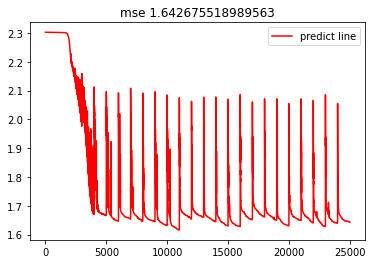

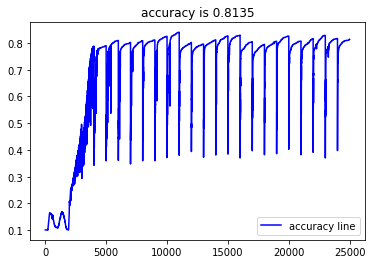

In [34]:
optimizer = optim.SGD(net1.parameters(), lr=0.1)
epochs = 1000
interval = 2000
epoch_list = []
loss_list = []
correct_list = []

for t in range(25):
    X_train_seg = X_train[t*interval: (t+1)*interval, 0:3, 0:32, 0:32].cuda()
    Y_train_seg = Y_train[t*interval:(t+1)*interval].cuda()
    for epoch in tnrange(epochs, desc='epoch'):
        optimizer.zero_grad()
        out = net1(X_train_seg)
        loss = net1.loss(out, Y_train_seg)
        loss.backward()
        optimizer.step()    # Does the update
        epoch_list.append(epoch + t * epochs)
        loss_list.append(loss.item())

        # accuracy
        pred = out.data.max(1, keepdim=False)[1]
        correct = pred.eq(Y_train_seg.data.view_as(pred)).cpu().detach().sum()
        correct_rate = correct.detach().item() / interval
        correct_list.append(correct_rate)

        if(epoch % 100 == 0):
            print(f"in {epoch}/{t}: loss is {loss}, accu is {correct_rate}")

fig, ax = plt.subplots()
sns.lineplot(x=epoch_list, y=loss_list, color='red', label='predict line', ax=ax)
plt.title(f"mse {loss}")
plt.show()

fig, ax = plt.subplots()
sns.lineplot(x=epoch_list, y=correct_list, color='blue', label='accuracy line', ax=ax)
plt.title(f"accuracy is {correct_rate}")
plt.show()

store
------------------------

In [35]:
path = '/content/drive/My Drive/Colab Notebooks/AI_relative/algorithm_explore/pretrained_model/CNN_CIFAR10_model.pt'
torch.save(net1.state_dict(), path)

reload
------------------------

In [47]:
import torch

In [48]:
path = '/content/drive/My Drive/Colab Notebooks/AI_relative/algorithm_explore/pretrained_model/CNN_CIFAR10_model.pt'
net1.load_state_dict(torch.load(path))
net1.eval()

CNN1(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=3000, bias=True)
  (fc2): Linear(in_features=3000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
  (ce): CrossEntropyLoss()
)

test set
-----------------------

In [49]:
out_test = net1(X_test.cuda())
out_test.size()

torch.Size([10000, 10])

In [50]:
pred = out_test.data.max(1, keepdim=False)[1]
correct = pred.eq(Y_test.cuda().data.view_as(pred)).cpu().detach().sum()
correct_rate = correct.detach().item() / pred.size()[0]
correct_rate

0.413

In [54]:
pred[3]

tensor(1, device='cuda:0')

In [82]:
list(out_test.cpu().data[0].detach().numpy())

[4.4893533e-10,
 7.884835e-06,
 0.30260476,
 4.961174e-06,
 5.8239146e-07,
 2.06346e-06,
 2.6622295e-06,
 4.4283804e-12,
 0.031270944,
 0.66610616]

In [88]:
list(out_test.cpu().data[5].detach().numpy())

[8.146689e-07,
 4.4983483e-12,
 1.4930045e-07,
 2.5112348e-09,
 1.6629857e-11,
 1.4246271e-10,
 0.99999905,
 7.088067e-12,
 8.210075e-13,
 1.0124152e-13]

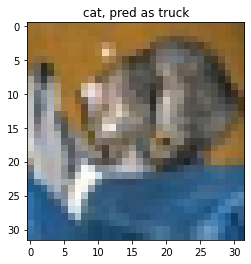

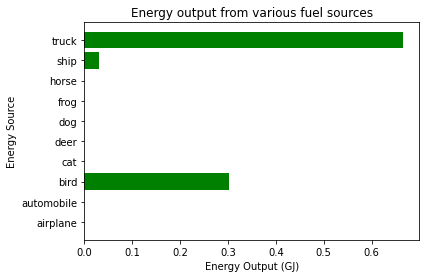

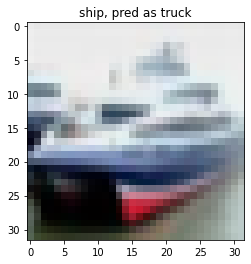

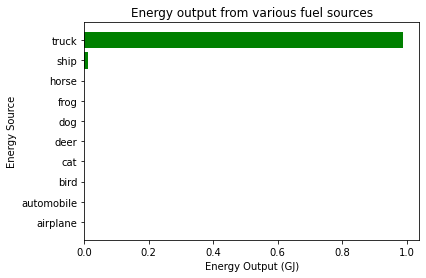

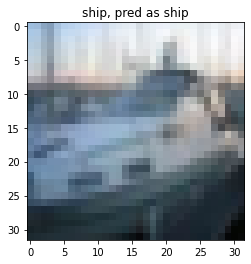

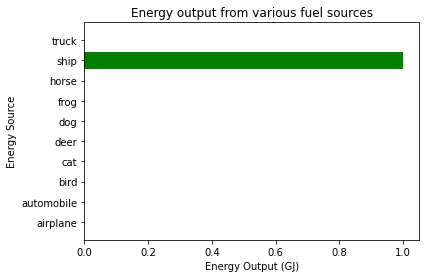

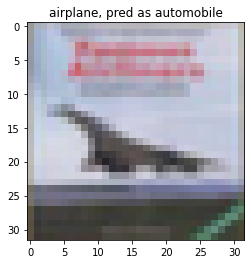

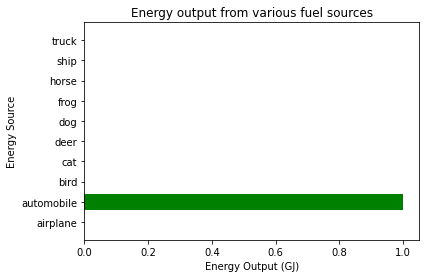

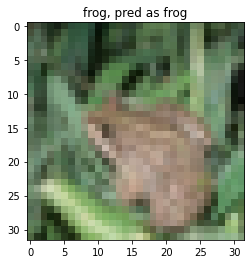

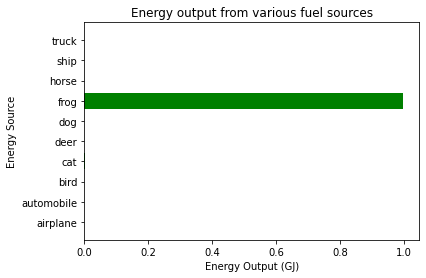

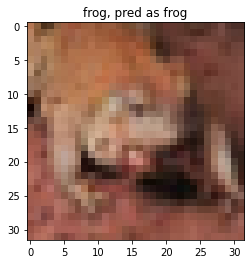

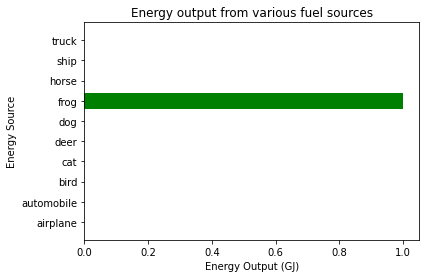

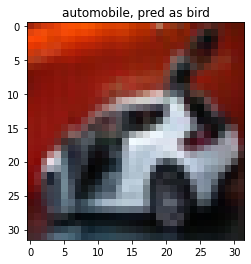

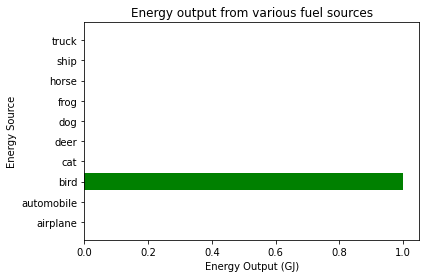

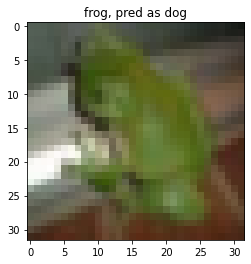

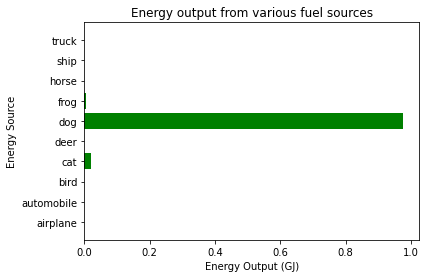

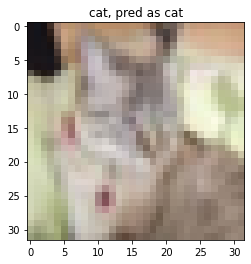

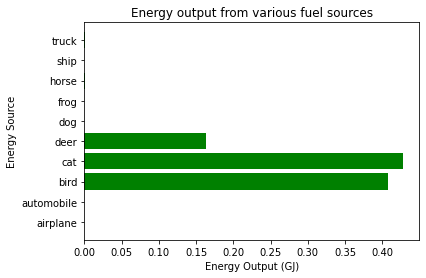

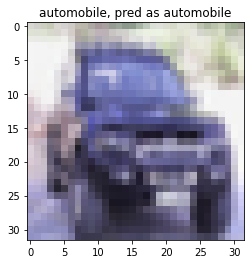

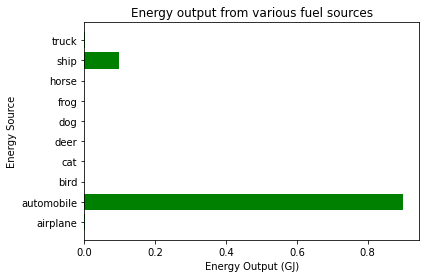

In [95]:
def show_image(i):
    label = {0:"airplane", 1:"automobile", 2:"bird", 3:"cat", 4:"deer", 
         5:"dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}
    plt.imshow(X_test_numpy[i])
    plt.title(f"{label.get(Y_test_numpy[i][0])}, pred as {label.get(pred[i].item())}")
    plt.show()

    x = list(label.values())
    x_pos = [i for i, _ in enumerate(x)]

    plt.barh(x, list(out_test.cpu().data[i].detach().numpy()), color='green')
    plt.ylabel("Energy Source")
    plt.xlabel("Energy Output (GJ)")
    plt.title("Energy output from various fuel sources")

    plt.yticks(x_pos, x)

    plt.show()

for i in range(10):
    show_image(i)

Update CNN2
=====================

In [23]:
from tqdm.notebook import tnrange, tqdm_notebook

In [24]:
Y_train.size()

torch.Size([50000])

in 0/0: loss is 2.034482955932617, accu is 0.424
in 100/0: loss is 1.9551448822021484, accu is 0.505
in 200/0: loss is 1.8988819122314453, accu is 0.5605
in 300/0: loss is 1.8862695693969727, accu is 0.573
in 400/0: loss is 1.880630373954773, accu is 0.5775
in 500/0: loss is 1.8643056154251099, accu is 0.5945
in 600/0: loss is 1.857319951057434, accu is 0.601
in 700/0: loss is 1.8522670269012451, accu is 0.606
in 800/0: loss is 1.8467013835906982, accu is 0.611
in 900/0: loss is 1.8417869806289673, accu is 0.616
in 1000/0: loss is 1.8400200605392456, accu is 0.618
in 1100/0: loss is 1.8369981050491333, accu is 0.6205
in 1200/0: loss is 1.8340256214141846, accu is 0.6235
in 1300/0: loss is 1.8333524465560913, accu is 0.624
in 1400/0: loss is 1.8321706056594849, accu is 0.625
in 1500/0: loss is 1.8318791389465332, accu is 0.625
in 1600/0: loss is 1.831424593925476, accu is 0.6255
in 1700/0: loss is 1.8291785717010498, accu is 0.628
in 1800/0: loss is 1.827033281326294, accu is 0.63
in 19

in 0/1: loss is 2.0415782928466797, accu is 0.4115
in 100/1: loss is 1.8755087852478027, accu is 0.5875
in 200/1: loss is 1.8417563438415527, accu is 0.6185
in 300/1: loss is 1.8361928462982178, accu is 0.623
in 400/1: loss is 1.8325819969177246, accu is 0.626
in 500/1: loss is 1.8249409198760986, accu is 0.634
in 600/1: loss is 1.8192265033721924, accu is 0.6395
in 700/1: loss is 1.8154330253601074, accu is 0.643
in 800/1: loss is 1.8149244785308838, accu is 0.643
in 900/1: loss is 1.8138731718063354, accu is 0.644
in 1000/1: loss is 1.8122113943099976, accu is 0.6455
in 1100/1: loss is 1.8120701313018799, accu is 0.6455
in 1200/1: loss is 1.8114495277404785, accu is 0.646
in 1300/1: loss is 1.8103505373001099, accu is 0.647
in 1400/1: loss is 1.8089834451675415, accu is 0.6485
in 1500/1: loss is 1.8067201375961304, accu is 0.651
in 1600/1: loss is 1.8045427799224854, accu is 0.6535
in 1700/1: loss is 1.8031814098358154, accu is 0.6545
in 1800/1: loss is 1.8017077445983887, accu is 0.

in 0/2: loss is 2.0217411518096924, accu is 0.4335
in 100/2: loss is 1.8458542823791504, accu is 0.616
in 200/2: loss is 1.8271840810775757, accu is 0.6335
in 300/2: loss is 1.8204671144485474, accu is 0.638
in 400/2: loss is 1.8186261653900146, accu is 0.6395
in 500/2: loss is 1.8170487880706787, accu is 0.641
in 600/2: loss is 1.814935326576233, accu is 0.643
in 700/2: loss is 1.8137768507003784, accu is 0.644
in 800/2: loss is 1.812441110610962, accu is 0.6455
in 900/2: loss is 1.8106350898742676, accu is 0.647
in 1000/2: loss is 1.8090457916259766, accu is 0.6485
in 1100/2: loss is 1.8088493347167969, accu is 0.6485
in 1200/2: loss is 1.8073689937591553, accu is 0.65
in 1300/2: loss is 1.8072190284729004, accu is 0.65
in 1400/2: loss is 1.8066637516021729, accu is 0.6505
in 1500/2: loss is 1.8061732053756714, accu is 0.651
in 1600/2: loss is 1.8057273626327515, accu is 0.6515
in 1700/2: loss is 1.8055987358093262, accu is 0.6515
in 1800/2: loss is 1.8055760860443115, accu is 0.6515

in 0/3: loss is 1.9947824478149414, accu is 0.4655
in 100/3: loss is 1.8884621858596802, accu is 0.5735
in 200/3: loss is 1.8168070316314697, accu is 0.643
in 300/3: loss is 1.8103983402252197, accu is 0.649
in 400/3: loss is 1.8089592456817627, accu is 0.65
in 500/3: loss is 1.8081951141357422, accu is 0.6505
in 600/3: loss is 1.8074992895126343, accu is 0.651
in 700/3: loss is 1.8059959411621094, accu is 0.6525
in 800/3: loss is 1.8053710460662842, accu is 0.653
in 900/3: loss is 1.8037199974060059, accu is 0.6545
in 1000/3: loss is 1.8018949031829834, accu is 0.6565
in 1100/3: loss is 1.8003325462341309, accu is 0.658
in 1200/3: loss is 1.7982617616653442, accu is 0.66
in 1300/3: loss is 1.797396183013916, accu is 0.661
in 1400/3: loss is 1.79469633102417, accu is 0.6635
in 1500/3: loss is 1.7944352626800537, accu is 0.6635
in 1600/3: loss is 1.7939090728759766, accu is 0.664
in 1700/3: loss is 1.793294906616211, accu is 0.6645
in 1800/3: loss is 1.7932755947113037, accu is 0.6645
i

in 0/4: loss is 1.987657904624939, accu is 0.47
in 100/4: loss is 1.872137188911438, accu is 0.589
in 200/4: loss is 1.8257672786712646, accu is 0.6335
in 300/4: loss is 1.8252190351486206, accu is 0.6335
in 400/4: loss is 1.824984073638916, accu is 0.6335
in 500/4: loss is 1.8238730430603027, accu is 0.6345
in 600/4: loss is 1.8227545022964478, accu is 0.6355
in 700/4: loss is 1.822158932685852, accu is 0.636
in 800/4: loss is 1.821575403213501, accu is 0.6365
in 900/4: loss is 1.821012258529663, accu is 0.637
in 1000/4: loss is 1.8195042610168457, accu is 0.6385
in 1100/4: loss is 1.8180551528930664, accu is 0.64
in 1200/4: loss is 1.8169240951538086, accu is 0.641
in 1300/4: loss is 1.8164381980895996, accu is 0.6415
in 1400/4: loss is 1.8157601356506348, accu is 0.642
in 1500/4: loss is 1.8148150444030762, accu is 0.643
in 1600/4: loss is 1.8145990371704102, accu is 0.643
in 1700/4: loss is 1.8145729303359985, accu is 0.643
in 1800/4: loss is 1.8137187957763672, accu is 0.644
in 19

in 0/5: loss is 1.9801182746887207, accu is 0.4795
in 100/5: loss is 1.8514485359191895, accu is 0.61
in 200/5: loss is 1.8334455490112305, accu is 0.626
in 300/5: loss is 1.8312370777130127, accu is 0.6275
in 400/5: loss is 1.8296395540237427, accu is 0.629
in 500/5: loss is 1.8289449214935303, accu is 0.6295
in 600/5: loss is 1.8287464380264282, accu is 0.6295
in 700/5: loss is 1.8280935287475586, accu is 0.63
in 800/5: loss is 1.8269739151000977, accu is 0.631
in 900/5: loss is 1.8260109424591064, accu is 0.632
in 1000/5: loss is 1.8254586458206177, accu is 0.6325
in 1100/5: loss is 1.8229423761367798, accu is 0.635
in 1200/5: loss is 1.821821689605713, accu is 0.636
in 1300/5: loss is 1.8207063674926758, accu is 0.637
in 1400/5: loss is 1.8201234340667725, accu is 0.6375
in 1500/5: loss is 1.8201134204864502, accu is 0.6375
in 1600/5: loss is 1.8191256523132324, accu is 0.6385
in 1700/5: loss is 1.8181473016738892, accu is 0.6395
in 1800/5: loss is 1.818091630935669, accu is 0.6395

in 0/6: loss is 1.9991180896759033, accu is 0.4595
in 100/6: loss is 1.8632029294967651, accu is 0.5985
in 200/6: loss is 1.8503793478012085, accu is 0.609
in 300/6: loss is 1.8459361791610718, accu is 0.613
in 400/6: loss is 1.841170072555542, accu is 0.618
in 500/6: loss is 1.8377342224121094, accu is 0.621
in 600/6: loss is 1.8364834785461426, accu is 0.622
in 700/6: loss is 1.835832953453064, accu is 0.6225
in 800/6: loss is 1.8741196393966675, accu is 0.588
in 900/6: loss is 1.826471209526062, accu is 0.6325
in 1000/6: loss is 1.8252508640289307, accu is 0.633
in 1100/6: loss is 1.8241981267929077, accu is 0.634
in 1200/6: loss is 1.8233699798583984, accu is 0.6345
in 1300/6: loss is 1.8227084875106812, accu is 0.635
in 1400/6: loss is 1.8220123052597046, accu is 0.6355
in 1500/6: loss is 1.8216787576675415, accu is 0.636
in 1600/6: loss is 1.8211652040481567, accu is 0.6365
in 1700/6: loss is 1.8197685480117798, accu is 0.638
in 1800/6: loss is 1.8180994987487793, accu is 0.6395


in 0/7: loss is 2.012002944946289, accu is 0.445
in 100/7: loss is 1.8803738355636597, accu is 0.5815
in 200/7: loss is 1.859425663948059, accu is 0.6015
in 300/7: loss is 1.8481398820877075, accu is 0.6105
in 400/7: loss is 1.8472344875335693, accu is 0.611
in 500/7: loss is 1.8457380533218384, accu is 0.6125
in 600/7: loss is 1.8439980745315552, accu is 0.614
in 700/7: loss is 1.8428881168365479, accu is 0.615
in 800/7: loss is 1.8422489166259766, accu is 0.6155
in 900/7: loss is 1.8421138525009155, accu is 0.6155
in 1000/7: loss is 1.8415096998214722, accu is 0.616
in 1100/7: loss is 1.8411355018615723, accu is 0.6165
in 1200/7: loss is 1.840928077697754, accu is 0.6165
in 1300/7: loss is 1.8409909009933472, accu is 0.6165
in 1400/7: loss is 1.8408654928207397, accu is 0.6165
in 1500/7: loss is 1.840848684310913, accu is 0.6165
in 1600/7: loss is 1.8408738374710083, accu is 0.6165
in 1700/7: loss is 1.8407208919525146, accu is 0.6165
in 1800/7: loss is 1.8402388095855713, accu is 0.

in 0/8: loss is 1.984201192855835, accu is 0.475
in 100/8: loss is 1.852538824081421, accu is 0.6095
in 200/8: loss is 1.8287559747695923, accu is 0.6305
in 300/8: loss is 1.8225891590118408, accu is 0.636
in 400/8: loss is 1.8197405338287354, accu is 0.6385
in 500/8: loss is 1.8189665079116821, accu is 0.639
in 600/8: loss is 1.816347360610962, accu is 0.6415
in 700/8: loss is 1.8150742053985596, accu is 0.6425
in 800/8: loss is 1.8114022016525269, accu is 0.6465
in 900/8: loss is 1.8110003471374512, accu is 0.6465
in 1000/8: loss is 1.8082691431045532, accu is 0.6495
in 1100/8: loss is 1.807761311531067, accu is 0.65
in 1200/8: loss is 1.8074595928192139, accu is 0.65
in 1300/8: loss is 1.8067888021469116, accu is 0.6505
in 1400/8: loss is 1.8067593574523926, accu is 0.6505
in 1500/8: loss is 1.8059399127960205, accu is 0.6515
in 1600/8: loss is 1.804826021194458, accu is 0.6525
in 1700/8: loss is 1.8037731647491455, accu is 0.6535
in 1800/8: loss is 1.8030509948730469, accu is 0.654

in 0/9: loss is 2.0004255771636963, accu is 0.456
in 100/9: loss is 1.86220121383667, accu is 0.5985
in 200/9: loss is 1.8471189737319946, accu is 0.612
in 300/9: loss is 1.8451790809631348, accu is 0.6135
in 400/9: loss is 1.8438632488250732, accu is 0.6145
in 500/9: loss is 1.8422449827194214, accu is 0.616
in 600/9: loss is 1.8415883779525757, accu is 0.6165
in 700/9: loss is 1.8403617143630981, accu is 0.6175
in 800/9: loss is 1.838913917541504, accu is 0.619
in 900/9: loss is 1.8373197317123413, accu is 0.6205
in 1000/9: loss is 1.833467721939087, accu is 0.6245
in 1100/9: loss is 1.831241250038147, accu is 0.6265
in 1200/9: loss is 1.8288434743881226, accu is 0.629
in 1300/9: loss is 1.8271815776824951, accu is 0.6305
in 1400/9: loss is 1.8257156610488892, accu is 0.632
in 1500/9: loss is 1.8254919052124023, accu is 0.632
in 1600/9: loss is 1.8240553140640259, accu is 0.6335
in 1700/9: loss is 1.8239061832427979, accu is 0.6335
in 1800/9: loss is 1.8232765197753906, accu is 0.634

in 0/10: loss is 1.994025707244873, accu is 0.4635
in 100/10: loss is 1.8409775495529175, accu is 0.621
in 200/10: loss is 1.815624475479126, accu is 0.6445
in 300/10: loss is 1.8110027313232422, accu is 0.648
in 400/10: loss is 1.810012698173523, accu is 0.6485
in 500/10: loss is 1.808905005455017, accu is 0.6495
in 600/10: loss is 1.8078405857086182, accu is 0.6505
in 700/10: loss is 1.806679368019104, accu is 0.6515
in 800/10: loss is 1.806466817855835, accu is 0.6515
in 900/10: loss is 1.8051514625549316, accu is 0.653
in 1000/10: loss is 1.803052544593811, accu is 0.655
in 1100/10: loss is 1.8023993968963623, accu is 0.6555
in 1200/10: loss is 1.802409052848816, accu is 0.6555
in 1300/10: loss is 1.8022775650024414, accu is 0.6555
in 1400/10: loss is 1.8022321462631226, accu is 0.6555
in 1500/10: loss is 1.8021764755249023, accu is 0.6555
in 1600/10: loss is 1.8021506071090698, accu is 0.6555
in 1700/10: loss is 1.8017045259475708, accu is 0.656
in 1800/10: loss is 1.8006570339202

in 0/11: loss is 1.982019305229187, accu is 0.477
in 100/11: loss is 1.8385015726089478, accu is 0.622
in 200/11: loss is 1.8296722173690796, accu is 0.6305
in 300/11: loss is 1.8244141340255737, accu is 0.635
in 400/11: loss is 1.823728322982788, accu is 0.635
in 500/11: loss is 1.8211649656295776, accu is 0.6375
in 600/11: loss is 1.8204985857009888, accu is 0.638
in 700/11: loss is 1.8180677890777588, accu is 0.6405
in 800/11: loss is 1.8178433179855347, accu is 0.6405
in 900/11: loss is 1.8172436952590942, accu is 0.641
in 1000/11: loss is 1.8171838521957397, accu is 0.641
in 1100/11: loss is 1.8166476488113403, accu is 0.6415
in 1200/11: loss is 1.815591812133789, accu is 0.6425
in 1300/11: loss is 1.8151330947875977, accu is 0.643
in 1400/11: loss is 1.8144950866699219, accu is 0.6435
in 1500/11: loss is 1.8134751319885254, accu is 0.6445
in 1600/11: loss is 1.8134019374847412, accu is 0.6445
in 1700/11: loss is 1.8128654956817627, accu is 0.645
in 1800/11: loss is 1.810100436210

in 0/12: loss is 1.992250680923462, accu is 0.467
in 100/12: loss is 1.8514248132705688, accu is 0.611
in 200/12: loss is 1.8350986242294312, accu is 0.6245
in 300/12: loss is 1.8330415487289429, accu is 0.626
in 400/12: loss is 1.8318240642547607, accu is 0.627
in 500/12: loss is 1.8305637836456299, accu is 0.6285
in 600/12: loss is 1.82861328125, accu is 0.63
in 700/12: loss is 1.8284770250320435, accu is 0.63
in 800/12: loss is 1.8272669315338135, accu is 0.6315
in 900/12: loss is 1.8249173164367676, accu is 0.6335
in 1000/12: loss is 1.824400782585144, accu is 0.634
in 1100/12: loss is 1.8234087228775024, accu is 0.635
in 1200/12: loss is 1.8227421045303345, accu is 0.6355
in 1300/12: loss is 1.8222699165344238, accu is 0.636
in 1400/12: loss is 1.8221691846847534, accu is 0.636
in 1500/12: loss is 1.8221184015274048, accu is 0.636
in 1600/12: loss is 1.8212504386901855, accu is 0.637
in 1700/12: loss is 1.819692611694336, accu is 0.6385
in 1800/12: loss is 1.8192341327667236, accu

in 0/13: loss is 2.0031960010528564, accu is 0.4565
in 100/13: loss is 1.8548959493637085, accu is 0.606
in 200/13: loss is 1.8174834251403809, accu is 0.643
in 300/13: loss is 1.8084447383880615, accu is 0.6505
in 400/13: loss is 1.8069921731948853, accu is 0.6515
in 500/13: loss is 1.8062455654144287, accu is 0.652
in 600/13: loss is 1.8060386180877686, accu is 0.652
in 700/13: loss is 1.8049161434173584, accu is 0.653
in 800/13: loss is 1.8048650026321411, accu is 0.653
in 900/13: loss is 1.8042715787887573, accu is 0.6535
in 1000/13: loss is 1.8041225671768188, accu is 0.6535
in 1100/13: loss is 1.803286075592041, accu is 0.6545
in 1200/13: loss is 1.8025816679000854, accu is 0.655
in 1300/13: loss is 1.8015542030334473, accu is 0.656
in 1400/13: loss is 1.801027536392212, accu is 0.6565
in 1500/13: loss is 1.8009403944015503, accu is 0.6565
in 1600/13: loss is 1.7998751401901245, accu is 0.6575
in 1700/13: loss is 1.7995327711105347, accu is 0.658
in 1800/13: loss is 1.79930961132

in 0/14: loss is 1.9959200620651245, accu is 0.4595
in 100/14: loss is 1.858156442642212, accu is 0.602
in 200/14: loss is 1.8439322710037231, accu is 0.615
in 300/14: loss is 1.8404107093811035, accu is 0.618
in 400/14: loss is 1.8354647159576416, accu is 0.623
in 500/14: loss is 1.8342341184616089, accu is 0.624
in 600/14: loss is 1.8324459791183472, accu is 0.6255
in 700/14: loss is 1.8306089639663696, accu is 0.6275
in 800/14: loss is 1.82915461063385, accu is 0.629
in 900/14: loss is 1.82650887966156, accu is 0.6315
in 1000/14: loss is 1.8233941793441772, accu is 0.6345
in 1100/14: loss is 1.8213213682174683, accu is 0.6365
in 1200/14: loss is 1.8189350366592407, accu is 0.639
in 1300/14: loss is 1.8168420791625977, accu is 0.641
in 1400/14: loss is 1.8157020807266235, accu is 0.642
in 1500/14: loss is 1.8154947757720947, accu is 0.642
in 1600/14: loss is 1.8154325485229492, accu is 0.642
in 1700/14: loss is 1.8144910335540771, accu is 0.643
in 1800/14: loss is 1.814571738243103, 

in 0/15: loss is 2.0014045238494873, accu is 0.457
in 100/15: loss is 1.8545516729354858, accu is 0.6055
in 200/15: loss is 1.849980354309082, accu is 0.609
in 300/15: loss is 1.8455283641815186, accu is 0.613
in 400/15: loss is 1.841465950012207, accu is 0.617
in 500/15: loss is 1.8384510278701782, accu is 0.62
in 600/15: loss is 1.8352817296981812, accu is 0.623
in 700/15: loss is 1.8346589803695679, accu is 0.6235
in 800/15: loss is 1.8292393684387207, accu is 0.629
in 900/15: loss is 1.8279407024383545, accu is 0.63
in 1000/15: loss is 1.8278796672821045, accu is 0.63
in 1100/15: loss is 1.8266199827194214, accu is 0.631
in 1200/15: loss is 1.826722502708435, accu is 0.631
in 1300/15: loss is 1.8261597156524658, accu is 0.6315
in 1400/15: loss is 1.8260990381240845, accu is 0.6315
in 1500/15: loss is 1.8248209953308105, accu is 0.6325
in 1600/15: loss is 1.823739767074585, accu is 0.634
in 1700/15: loss is 1.822023630142212, accu is 0.6355
in 1800/15: loss is 1.8218368291854858, ac

in 0/16: loss is 2.0022146701812744, accu is 0.456
in 100/16: loss is 1.85755455493927, accu is 0.6035
in 200/16: loss is 1.8372634649276733, accu is 0.6215
in 300/16: loss is 1.8336381912231445, accu is 0.6245
in 400/16: loss is 1.8311412334442139, accu is 0.627
in 500/16: loss is 1.8302711248397827, accu is 0.6275
in 600/16: loss is 1.8290842771530151, accu is 0.6285
in 700/16: loss is 1.8281276226043701, accu is 0.6295
in 800/16: loss is 1.825899362564087, accu is 0.6315
in 900/16: loss is 1.8254258632659912, accu is 0.632
in 1000/16: loss is 1.8229060173034668, accu is 0.6345
in 1100/16: loss is 1.8209543228149414, accu is 0.6365
in 1200/16: loss is 1.8198999166488647, accu is 0.6375
in 1300/16: loss is 1.8198529481887817, accu is 0.6375
in 1400/16: loss is 1.8198411464691162, accu is 0.6375
in 1500/16: loss is 1.8192188739776611, accu is 0.638
in 1600/16: loss is 1.8191362619400024, accu is 0.638
in 1700/16: loss is 1.8187469244003296, accu is 0.6385
in 1800/16: loss is 1.81725025

in 0/17: loss is 1.9854644536972046, accu is 0.4745
in 100/17: loss is 1.8481786251068115, accu is 0.6125
in 200/17: loss is 1.843596339225769, accu is 0.6155
in 300/17: loss is 1.8386598825454712, accu is 0.62
in 400/17: loss is 1.835973858833313, accu is 0.6225
in 500/17: loss is 1.8339815139770508, accu is 0.6245
in 600/17: loss is 1.8326804637908936, accu is 0.6255
in 700/17: loss is 1.8316808938980103, accu is 0.6265
in 800/17: loss is 1.8297851085662842, accu is 0.6285
in 900/17: loss is 1.8289644718170166, accu is 0.629
in 1000/17: loss is 1.8284004926681519, accu is 0.6295
in 1100/17: loss is 1.8268786668777466, accu is 0.631
in 1200/17: loss is 1.8262070417404175, accu is 0.6315
in 1300/17: loss is 1.826278805732727, accu is 0.6315
in 1400/17: loss is 1.8259632587432861, accu is 0.6315
in 1500/17: loss is 1.8250422477722168, accu is 0.6325
in 1600/17: loss is 1.8249772787094116, accu is 0.6325
in 1700/17: loss is 1.8244763612747192, accu is 0.633
in 1800/17: loss is 1.82369506

in 0/18: loss is 2.0038533210754395, accu is 0.4555
in 100/18: loss is 1.8703527450561523, accu is 0.5895
in 200/18: loss is 1.8615920543670654, accu is 0.5975
in 300/18: loss is 1.8543059825897217, accu is 0.605
in 400/18: loss is 1.8523674011230469, accu is 0.606
in 500/18: loss is 1.8507585525512695, accu is 0.6075
in 600/18: loss is 1.8501852750778198, accu is 0.608
in 700/18: loss is 1.8482033014297485, accu is 0.61
in 800/18: loss is 1.8480799198150635, accu is 0.61
in 900/18: loss is 1.8465917110443115, accu is 0.6115
in 1000/18: loss is 1.8451895713806152, accu is 0.6125
in 1100/18: loss is 1.844751000404358, accu is 0.613
in 1200/18: loss is 1.8437614440917969, accu is 0.614
in 1300/18: loss is 1.8428542613983154, accu is 0.615
in 1400/18: loss is 1.8427104949951172, accu is 0.615
in 1500/18: loss is 1.8406320810317993, accu is 0.617
in 1600/18: loss is 1.8398305177688599, accu is 0.6175
in 1700/18: loss is 1.8388508558273315, accu is 0.619
in 1800/18: loss is 1.83829581737518

in 0/19: loss is 1.9736344814300537, accu is 0.486
in 100/19: loss is 1.8289945125579834, accu is 0.631
in 200/19: loss is 1.8212131261825562, accu is 0.638
in 300/19: loss is 1.8178598880767822, accu is 0.641
in 400/19: loss is 1.8151799440383911, accu is 0.6435
in 500/19: loss is 1.8130073547363281, accu is 0.6455
in 600/19: loss is 1.8127915859222412, accu is 0.6455
in 700/19: loss is 1.8122971057891846, accu is 0.646
in 800/19: loss is 1.8111796379089355, accu is 0.647
in 900/19: loss is 1.8100851774215698, accu is 0.648
in 1000/19: loss is 1.8094902038574219, accu is 0.6485
in 1100/19: loss is 1.8090527057647705, accu is 0.649
in 1200/19: loss is 1.8080183267593384, accu is 0.65
in 1300/19: loss is 1.807032585144043, accu is 0.651
in 1400/19: loss is 1.805967926979065, accu is 0.652
in 1500/19: loss is 1.8050570487976074, accu is 0.653
in 1600/19: loss is 1.8044378757476807, accu is 0.6535
in 1700/19: loss is 1.8039921522140503, accu is 0.654
in 1800/19: loss is 1.8029847145080566

in 0/20: loss is 1.98393976688385, accu is 0.4735
in 100/20: loss is 1.8369834423065186, accu is 0.623
in 200/20: loss is 1.8262394666671753, accu is 0.633
in 300/20: loss is 1.8247884511947632, accu is 0.634
in 400/20: loss is 1.8216313123703003, accu is 0.637
in 500/20: loss is 1.820868968963623, accu is 0.6375
in 600/20: loss is 1.8184130191802979, accu is 0.64
in 700/20: loss is 1.817635416984558, accu is 0.6405
in 800/20: loss is 1.8167227506637573, accu is 0.6415
in 900/20: loss is 1.816582202911377, accu is 0.6415
in 1000/20: loss is 1.8148744106292725, accu is 0.6435
in 1100/20: loss is 1.8136157989501953, accu is 0.6445
in 1200/20: loss is 1.8130334615707397, accu is 0.645
in 1300/20: loss is 1.812949538230896, accu is 0.645
in 1400/20: loss is 1.8128588199615479, accu is 0.645
in 1500/20: loss is 1.812284231185913, accu is 0.6455
in 1600/20: loss is 1.8104926347732544, accu is 0.6475
in 1700/20: loss is 1.8093812465667725, accu is 0.6485
in 1800/20: loss is 1.8088445663452148

in 0/21: loss is 1.9763280153274536, accu is 0.484
in 100/21: loss is 1.8458460569381714, accu is 0.6135
in 200/21: loss is 1.8270009756088257, accu is 0.632
in 300/21: loss is 1.8249139785766602, accu is 0.6335
in 400/21: loss is 1.8222604990005493, accu is 0.636
in 500/21: loss is 1.8206195831298828, accu is 0.6375
in 600/21: loss is 1.8193442821502686, accu is 0.6385
in 700/21: loss is 1.8181999921798706, accu is 0.6395
in 800/21: loss is 1.8175337314605713, accu is 0.6405
in 900/21: loss is 1.8161100149154663, accu is 0.6415
in 1000/21: loss is 1.813765287399292, accu is 0.644
in 1100/21: loss is 1.8135799169540405, accu is 0.644
in 1200/21: loss is 1.8134675025939941, accu is 0.644
in 1300/21: loss is 1.8128868341445923, accu is 0.6445
in 1400/21: loss is 1.81294846534729, accu is 0.6445
in 1500/21: loss is 1.8123396635055542, accu is 0.645
in 1600/21: loss is 1.8122094869613647, accu is 0.645
in 1700/21: loss is 1.8122206926345825, accu is 0.645
in 1800/21: loss is 1.812025308609

in 0/22: loss is 1.9921103715896606, accu is 0.4655
in 100/22: loss is 1.8546932935714722, accu is 0.608
in 200/22: loss is 1.8217800855636597, accu is 0.6375
in 300/22: loss is 1.8124529123306274, accu is 0.646
in 400/22: loss is 1.8074849843978882, accu is 0.651
in 500/22: loss is 1.805398941040039, accu is 0.653
in 600/22: loss is 1.8026278018951416, accu is 0.6555
in 700/22: loss is 1.8004032373428345, accu is 0.6575
in 800/22: loss is 1.8003716468811035, accu is 0.6575
in 900/22: loss is 1.7997642755508423, accu is 0.658
in 1000/22: loss is 1.7987784147262573, accu is 0.659
in 1100/22: loss is 1.7982494831085205, accu is 0.6595
in 1200/22: loss is 1.798139214515686, accu is 0.6595
in 1300/22: loss is 1.7976323366165161, accu is 0.66
in 1400/22: loss is 1.7971123456954956, accu is 0.6605
in 1500/22: loss is 1.7970693111419678, accu is 0.6605
in 1600/22: loss is 1.7965208292007446, accu is 0.661
in 1700/22: loss is 1.7945700883865356, accu is 0.663
in 1800/22: loss is 1.794486880302

in 0/23: loss is 1.9851045608520508, accu is 0.471
in 100/23: loss is 1.8624229431152344, accu is 0.5995
in 200/23: loss is 1.842895269393921, accu is 0.616
in 300/23: loss is 1.8403257131576538, accu is 0.618
in 400/23: loss is 1.836917519569397, accu is 0.6215
in 500/23: loss is 1.8332440853118896, accu is 0.625
in 600/23: loss is 1.8256880044937134, accu is 0.633
in 700/23: loss is 1.8240195512771606, accu is 0.634
in 800/23: loss is 1.8215783834457397, accu is 0.6365
in 900/23: loss is 1.8203339576721191, accu is 0.6375
in 1000/23: loss is 1.8201346397399902, accu is 0.6375
in 1100/23: loss is 1.8195984363555908, accu is 0.638
in 1200/23: loss is 1.8189364671707153, accu is 0.6385
in 1300/23: loss is 1.8167102336883545, accu is 0.641
in 1400/23: loss is 1.8151721954345703, accu is 0.6425
in 1500/23: loss is 1.813534140586853, accu is 0.644
in 1600/23: loss is 1.8124034404754639, accu is 0.645
in 1700/23: loss is 1.811103343963623, accu is 0.6465
in 1800/23: loss is 1.81090819835662

in 0/24: loss is 1.9816546440124512, accu is 0.4765
in 100/24: loss is 1.8434747457504272, accu is 0.617
in 200/24: loss is 1.8390945196151733, accu is 0.62
in 300/24: loss is 1.8372477293014526, accu is 0.6215
in 400/24: loss is 1.8341957330703735, accu is 0.6245
in 500/24: loss is 1.830648422241211, accu is 0.628
in 600/24: loss is 1.827665090560913, accu is 0.631
in 700/24: loss is 1.826401710510254, accu is 0.632
in 800/24: loss is 1.8257874250411987, accu is 0.6325
in 900/24: loss is 1.8238219022750854, accu is 0.6345
in 1000/24: loss is 1.823716163635254, accu is 0.6345
in 1100/24: loss is 1.8217668533325195, accu is 0.6365
in 1200/24: loss is 1.8210551738739014, accu is 0.637
in 1300/24: loss is 1.8205273151397705, accu is 0.6375
in 1400/24: loss is 1.8199925422668457, accu is 0.638
in 1500/24: loss is 1.818456768989563, accu is 0.6395
in 1600/24: loss is 1.8182833194732666, accu is 0.6395
in 1700/24: loss is 1.818278431892395, accu is 0.6395
in 1800/24: loss is 1.81782567501068

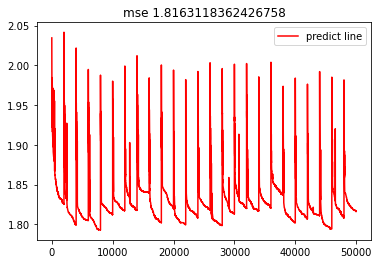

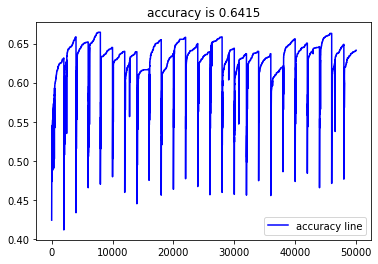

In [28]:
optimizer = optim.SGD(net2.parameters(), lr=0.1)
epochs = 2000
interval = 2000
epoch_list = []
loss_list = []
correct_list = []

for t in range(25):
    X_train_seg = X_train[t*interval: (t+1)*interval, 0:3, 0:32, 0:32].cuda()
    Y_train_seg = Y_train[t*interval:(t+1)*interval].cuda()
    for epoch in tnrange(epochs, desc='epoch'):
        optimizer.zero_grad()
        out = net2(X_train_seg)
        loss = net2.loss(out, Y_train_seg)
        loss.backward()
        optimizer.step()    # Does the update
        epoch_list.append(epoch + t * epochs)
        loss_list.append(loss.item())

        # accuracy
        pred = out.data.max(1, keepdim=False)[1]
        correct = pred.eq(Y_train_seg.data.view_as(pred)).cpu().detach().sum()
        correct_rate = correct.detach().item() / interval
        correct_list.append(correct_rate)

        if(epoch % 100 == 0):
            print(f"in {epoch}/{t}: loss is {loss}, accu is {correct_rate}")

fig, ax = plt.subplots()
sns.lineplot(x=epoch_list, y=loss_list, color='red', label='predict line', ax=ax)
plt.title(f"mse {loss}")
plt.show()

fig, ax = plt.subplots()
sns.lineplot(x=epoch_list, y=correct_list, color='blue', label='accuracy line', ax=ax)
plt.title(f"accuracy is {correct_rate}")
plt.show()

test set
--------------

In [29]:
out_test = net2(X_test.cuda())
out_test.size()

torch.Size([10000, 10])

In [30]:
pred = out_test.data.max(1, keepdim=False)[1]
correct = pred.eq(Y_test.cuda().data.view_as(pred)).cpu().detach().sum()
correct_rate = correct.detach().item() / pred.size()[0]
correct_rate

0.4719